In [1]:
import csv
import gensim
import keras
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
from key_words_extract import *

from tqdm import tqdm

from scipy.spatial.distance import cosine

from keras.preprocessing import sequence, text
from keras.utils.np_utils import to_categorical


from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer

Using TensorFlow backend.


In [2]:
RANDOM_SEED = 42
NB_CATEGORIES = 51
PADDING = 100
PRE_TRAINED_DIM = 300
REDUCED_DIM = 100
NB_KEYWORDS = 10

dataDirPath = './challenge_data'
embeddingsDirPath = './../word_embeddings/'
xPath = os.path.join(dataDirPath, 'input_train.csv')
yPath = os.path.join(dataDirPath, 'output_train.csv')
xTestPath = os.path.join(dataDirPath, 'input_test.csv')
#embeddingPath = os.path.join(embeddingsDirPath, 'wiki.fr.vec')
#embeddingPath = os.path.join(embeddingsDirPath, 'retrained_fr.vec')
embeddingPath = os.path.join(embeddingsDirPath, 'retrained_questions.vec')

## Loading Word Embeddings

In [3]:
'''pretrainedEmbeddings = gensim.models.KeyedVectors.\
    load_word2vec_format(embeddingPath, binary=False)'''

'pretrainedEmbeddings = gensim.models.KeyedVectors.    load_word2vec_format(embeddingPath, binary=False)'

## Load data

In [4]:
x = pd.read_csv(xPath, delimiter=';', usecols=[1]).values.ravel()
xTest = pd.read_csv(xTestPath, delimiter=';', usecols=[1]).values.ravel()
y = pd.read_csv(yPath, delimiter=';', usecols=[1]).values.ravel()

## Preprocessing

In [5]:
correctionsDict = {}
correctionsPath = os.path.join(dataDirPath, 'corrections.csv')

with open(correctionsPath, 'r') as f:
    for key, val in csv.reader(f):
        correctionsDict[key] = val

def spellingCorrection(sentence, correctionsDict={}, verbose=False):
    correctedSentence = []
    nb_corrections = 0
    for word in sentence.split():
        if word in correctionsDict.keys():
            word = correctionsDict[word]
            nb_corrections += 1
        correctedSentence.append(word)
    if verbose:
        return ' '.join(correctedSentence), nb_corrections
    else:
        return ' '.join(correctedSentence)

nb_corr = 0
for i, s in enumerate(x):
    cor = spellingCorrection(s, correctionsDict, verbose = True)
    x[i] = cor[0]
    nb_corr += cor[1]

for i, s in enumerate(xTest):
    cor = spellingCorrection(s, correctionsDict, verbose = True)
    xTest[i] = cor[0]
    nb_corr += cor[1]
print(nb_corr)

7973


In [6]:
class CustomModel():
    '''Generic workflow class.'''

    def __init__(self, **kwargs):
        self.verbose = kwargs.get('verbose', False)
        self.nbCategories = kwargs['nbCategories']
        self.paddingLength = PADDING
        self.tokenizer = text.Tokenizer(num_words=1e5, 
                                        filters="!\"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n'´’™©®«»",
                                        split=" ")
    
    def tokenizer_fit(self, x):
        self.tokenizer.fit_on_texts(x)
    
    def tokenize(self, x):
        x = self.tokenizer.texts_to_sequences(x)
        x = sequence.pad_sequences(x, PADDING)
        return x
    
    def buildKeywords(self, x, y, k):
        self.kwords, self.kweights = keyWordsExtract(x=x, y=y, k=k, toVector=True)
        return self.kwords
        
    def build_tfidf(self, x, xTest=None):
        self.tfidf = TfidfVectorizer(input = 'content')
        xTrain = self.tfidf.fit_transform(x)
        if xTest is not None:
            xTest = self.tfidf.transform(xTest)
            return xTrain, xTest
        else:
            return xTrain

    def buildFeatures(self, x, k, embeddings):
        x_feat = np.zeros((x.shape[0], k*self.nbCategories))
        kindices = np.array([self.tokenizer.word_index[w] for w in self.kwords])
        print(x.shape)
        for i in tqdm(np.arange(x.shape[0])):
            xx = x[i]
            for j, keyword in enumerate(kindices):
                if keyword in xx:
                    x_feat[i, j] = 1
        return x_feat
    
    def train_xgboost(self, x, y):
        return
       
    def evaluate(self, x, y):
        return self.model.evaluate(x, y)

    def predict(self, x):
        return self.model.predict(x)

### Tokenizing

In [7]:
# we need to create the model here
model = CustomModel(verbose=True, nbCategories=NB_CATEGORIES)
model.tokenizer_fit(np.concatenate((x, xTest)))
vocabulary = model.tokenizer.word_index.keys()
print('Vocabulary size: ', len(vocabulary))

Vocabulary size:  10175


#### TFIDF features

In [8]:
#xTrain_tf, xTest_tf = model.build_tfidf(x, xTest)

#### Keywords features

In [9]:
# if a dictionnary {cat: [keywords]} is wanted, set toVector = False
#model.buildKeywords(x, y, k = NB_KEYWORDS)

#x = model.tokenize(x)
#xTest = model.tokenize(xTest)
#y = to_categorical(y, num_classes=NB_CATEGORIES)

In [10]:
MEDICAMENTS = []

with open(os.path.join(dataDirPath, 'medicList.txt')) as f:
    for line in f:
        MEDICAMENTS.append(line.lower().rstrip())

print('Liste de médicaments regroupant les libéllés ATC et les'
      'dénominations de spécialité, de taille: {}'.format(len(MEDICAMENTS)))
print('Sample of medicament names: ', MEDICAMENTS[:10])

Liste de médicaments regroupant les libéllés ATC et lesdénominations de spécialité, de taille: 8390
Sample of medicament names:  ['a 313 200  pour cent', 'a 313 50 000 u.i', 'abacavir', 'abacavir/lamivudine', 'abacavir/lamivudine pharma', 'abacavir/lamivudine pharos', 'abamipharm', 'abboticine', 'abelcet', 'abstral']


In [11]:
from unidecode import unidecode

embeddings = np.zeros((len(vocabulary) + 1 , PRE_TRAINED_DIM))
not_in_pretrained = []
detected_medic = []

for word, idx in model.tokenizer.word_index.items():
    if word not in pretrainedEmbeddings.vocab:
        unaccented = unidecode(word)
        if word in MEDICAMENTS:
            vec = pretrainedEmbeddings['médicament']
            detected_medic.append(word)
        else:
            vec = np.zeros(PRE_TRAINED_DIM)
            not_in_pretrained.append(word)
    else:
        vec = pretrainedEmbeddings[word]

    # word_to_index is 1-based! the 0-th row, used for padding, stays at zero
    embeddings[idx,] = vec

print('---------- Embedding Created ----------')
print('Number of words in corpus that do not appear in '
      'pretrained Fasttext: ', len(not_in_pretrained))
print('size of the embedding: {}'.format(embeddings.shape))

from sklearn.decomposition import PCA
pca = PCA(n_components=REDUCED_DIM)
reducedEmbeddings = pca.fit_transform(embeddings)

## Key Words features

In [12]:
#xTrain, xValid, yTrain, yValid = train_test_split(x, y, test_size=.2,random_state=RANDOM_SEED)

In [13]:
#fTrain = model.buildFeatures(x=xTrain, k=NB_KEYWORDS, embeddings=reducedEmbeddings)

In [14]:
#fValid = model.buildFeatures(x=xValid, k=NB_KEYWORDS, embeddings=reducedEmbeddings)

## Classifiers with tfidf features

### Random forest

In [15]:
xTrain_r, xValid_r, yTrain, yValid = train_test_split(x, y, test_size = .2, random_state=RANDOM_SEED)
xTrain, xValid = model.build_tfidf(xTrain_r, xValid_r)

In [38]:
clf = RandomForestClassifier(n_estimators= 100, verbose =0, max_depth=None, min_samples_split=2, min_samples_leaf=1)
clf = clf.fit(xTrain, yTrain)

In [39]:
predictionCategories = clf.predict(xValid)
accuracy = accuracy_score(yValid, predictionCategories)
print("Accuracy: {}".format(accuracy*100.0))

Accuracy: 61.08343711083437


### Perceptron

In [18]:
from sklearn.linear_model import Perceptron

In [19]:
clf = Perceptron(penalty = 'l2', alpha = 0.00001, verbose = 0, max_iter=1000, tol=1e-3)
clf = clf.fit(xTrain, yTrain)

In [20]:
predictionCategories = clf.predict(xValid)
accuracy = accuracy_score(yValid, predictionCategories)
print("Accuracy: {}".format(accuracy*100.0))

Accuracy: 59.02864259028643


### RBF SVM

In [21]:
from sklearn.svm import SVC
clf = SVC(C=10000, kernel='rbf', degree=3, tol=0.001, verbose=True, max_iter=-1)
clf = clf.fit(xTrain, yTrain)

[LibSVM]

In [22]:
predictionCategories = clf.predict(xValid)
accuracy = accuracy_score(yValid, predictionCategories)
print("Accuracy: {}".format(accuracy*100.0))

Accuracy: 66.81195516811955


### Linear SVM

In [53]:
from sklearn.svm import LinearSVC
clf = LinearSVC(penalty = 'l2', max_iter = 10000, loss='squared_hinge', dual=True, tol=0.00001, C=1, verbose = 1, multi_class='ovr')
clf = clf.fit(xTrain, yTrain)

[LibLinear]

In [54]:

predictionCategories = clf.predict(xTrain)
accuracy = accuracy_score(yTrain, predictionCategories)
print("train-accuracy: {}".format(accuracy*100.0))
predictionCategories = clf.predict(xValid)
accuracy = accuracy_score(yValid, predictionCategories)
print("Test-accuracy: {}".format(accuracy*100.0))

train-accuracy: 98.34942385549674
Test-accuracy: 68.8667496886675


### NN

In [25]:
xxTrain = xTrain.todense()
xxValid = xValid.todense()
yyTrain = keras.utils.np_utils.to_categorical(yTrain, 51)
yyValid = keras.utils.np_utils.to_categorical(yValid, 51)

nb_feats = xTrain.shape[1]
my_input = keras.Input(shape=(nb_feats,), name = 'input')
dense1 = keras.layers.Dense(256, activation ='relu', name ='dense1')(my_input)
drop1 = keras.layers.Dropout(0.3)(dense1)
dense2 = keras.layers.Dense(256, activation ='relu', name ='dense2')(drop1)
drop2 = keras.layers.Dropout(0.3)(dense2)
prob = keras.layers.Dense(51, activation ='softmax', name ='output')(drop2)
clf = keras.Model(my_input, prob)
clf.compile(loss='categorical_crossentropy', 
            optimizer = 'adam', metrics =['accuracy'])
clf.summary()

clf.fit(xxTrain, yyTrain, validation_data=(xxValid, yyValid),
        epochs=5, batch_size = 32)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           (None, 8162)              0         
_________________________________________________________________
dense1 (Dense)               (None, 256)               2089728   
_________________________________________________________________
dropout_1 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense2 (Dense)               (None, 256)               65792     
_________________________________________________________________
dropout_2 (Dropout)          (None, 256)               0         
_________________________________________________________________
output (Dense)               (None, 51)                13107     
Total params: 2,168,627
Trainable params: 2,168,627
Non-trainable params: 0
_________________________________________________________________


## Vizualisation of the classification results

In [26]:
import collections

In [27]:
yPosition = np.arange(2*NB_CATEGORIES)

c = collections.Counter(yValid)
od = collections.OrderedDict(sorted(c.items(), key=lambda x: x[0]))
cp = collections.Counter(predictionCategories)
odp = collections.OrderedDict(sorted(cp.items(), key=lambda x: x[0]))

correctResults = predictionCategories[predictionCategories == yValid]
cc = collections.Counter(correctResults)
odc = collections.OrderedDict(sorted(cc.items(), key=lambda x: x[0]))

In [28]:
pod = np.zeros(2*NB_CATEGORIES)
for key in od:
    pod[2*key] = od[key]

podp = np.zeros(2*NB_CATEGORIES)
for key in odp:
    podp[2*key+1] = odp[key]

podc = np.zeros(2*NB_CATEGORIES)
for key in odc:
    podc[2*key+1] = odc[key]

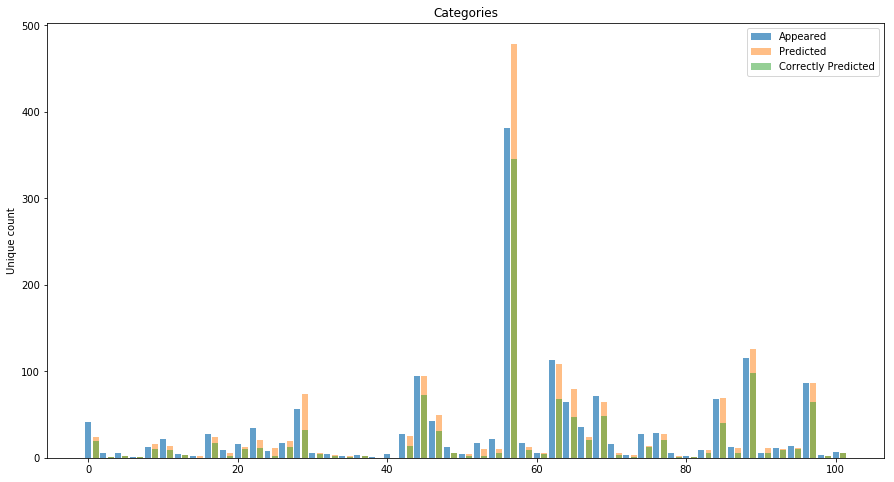

In [29]:
plt.figure(figsize=(15,8))
#plt.yscale('log')

plt.bar(yPosition, pod, alpha=0.7, label='Appeared')
plt.bar(yPosition, podp, alpha=0.5, label='Predicted')
plt.bar(yPosition, podc, alpha=0.5, label='Correctly Predicted')

plt.ylabel('Unique count')
plt.title('Categories')
plt.legend()
 
plt.show()

## Exportation for sankey diagram

In [30]:
sankeyEdges = np.zeros((NB_CATEGORIES, NB_CATEGORIES))

for i, category in enumerate(yValid):
    # if we only want to see the pred errors
    if category != predictionCategories[i]:
        sankeyEdges[category, predictionCategories[i]] += 1

with open('./challenge_data/evaluation_errors_lSVM.csv', 'w+') as f:
    f.write('source;target;value\n')

    for i in range(NB_CATEGORIES):
        for j in range(NB_CATEGORIES):
            if sankeyEdges[i,j] > 0:
                f.write('{}s;{}t;{}\n'.format(str(i), str(j), str(int(sankeyEdges[i,j]))))

### Final prediction on all the training set and export

In [31]:
from sklearn.svm import LinearSVC
clf = LinearSVC(penalty = 'l2', max_iter = 1000, loss='squared_hinge', dual=True, tol=0.0001, C=1, verbose = 1)
clf = clf.fit(xTrain_tf, y)

NameError: name 'xTrain_tf' is not defined

In [ ]:
exportY = clf.predict(xTest_tf)
exportY

In [ ]:
with open(os.path.join(dataDirPath, 'output_linearSVC.csv'), 'w+') as f:
    f.write('ID;intention\n')

    for i, p in enumerate(exportY):
        f.write('{};{}\n'.format(str(i), str(p)))

## Exploration of what went wrong

In [36]:
w_pred = {}
t_pred = {}
for c in np.arange(NB_CATEGORIES):
    w_pred[c] = []
    t_pred[c] = []

for q, t_lab, pred_lab in zip(xValid_r, yValid, predictionCategories):
    if pred_lab == t_lab:
        t_pred[t_lab].append(tuple((pred_lab, q)))
    else:
        w_pred[t_lab].append(tuple((pred_lab, q)))

In [37]:
ix = 0
print('----------true predictions------------')
print(t_pred[ix][:10])
print('-----------wrong prediction------------')
w_pred[ix]

----------true predictions------------
[(0, 'Quelle alternative à la rupture de Havrix ?'), (0, 'Quelle alternative au plavix ?'), (0, 'puis je prendre lectil à la place de serc ou bétaserc?'), (0, 'Quelle alternative au méningite en cas de rupture ?'), (0, "Si cycline pour acné, que faire pour remplacer pendant l'été ?"), (0, 'Est-ce que le pneumovax est équivalent au pneumo 23 ?'), (0, 'Quelle alternative thérapeutique à l’erphilus pour un bébé quand la prise est compliquée?'), (0, 'deroxat similaire à prozac ??'), (0, "je souffre d'une hyper pilosité et mon dermatologue m'a prescrit de l'androcur mais je ne le supporte pas. je voulais savoir s'il existait un autre traitement contre l'hyperpilosité ?"), (0, 'par quoi puis je remplacer engerix?')]
-----------wrong prediction------------


[(21,
  "je suis actuellement en sevrage de plusieurs médicaments: xanax et stilnox. il y a un mois j'etais en sevrage sec de lamictal (thymo) et theralene (hypno). ils se font effectues avec succès, aucun manque. aujourd'hui mon traitement se compose de depakote 100 mg (je suis bipolaire), de 3 xanax de 0.5 (auparavent 4) j'ai beaucoup de mal a diminuer. et tercian, neuroleptique que j'aimerais arrêter donc me sevrer car il me shoote trop et c'est pas compatible avec le travail. de plus il me fait prendre bip de poids. le tableau: je suis insomniaque depuis 15 ans rien a faire alors je prends chaque soir un peu de mélatonine (5mg) et CA m'aide bcp. est ce une bonne idée de remplacer le tercian qui m'est donne pour dormir par de la melatonine?"),
 (44,
  'Le Cérat de alien contre indiqué chez les enfants de moins de 3 ans, quelle alternative ?'),
 (5, 'for et priopix la mémé chose ou pas?'),
 (10, 'changement diane 35 --> ?'),
 (22, '2 engerix 10 = 1 engerix 20???'),
 (28,
  "Je suis s